A simple re-implementation of the GP from [Gorda et al](http://arxiv.org/abs/2204.11877).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from scipy.integrate import cumulative_trapezoid
from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre,
    dyn_per_square_cm_to_GeV_per_cubic_femtometer,
    nsat
    )

In [2]:
rng = np.random.default_rng()

At low densities we have a crust model. We'll want to attach our EOS draws to this. We use the BPS EOS from https://arxiv.org/abs/1303.4662.

In [3]:
crust = pd.read_csv('../data/bps_eos.csv')

In [4]:
crust_number_density = crust['n/n0'].values*nsat
crust_pressure = crust['p'].values/1000
crust_energy_density = crust['epsilon'].values/1000

crust_chemical_potential = (
    crust_energy_density+crust_pressure
    )/crust_number_density

crust_speed_of_sound_squared = np.gradient(
    crust_pressure, crust_energy_density
)

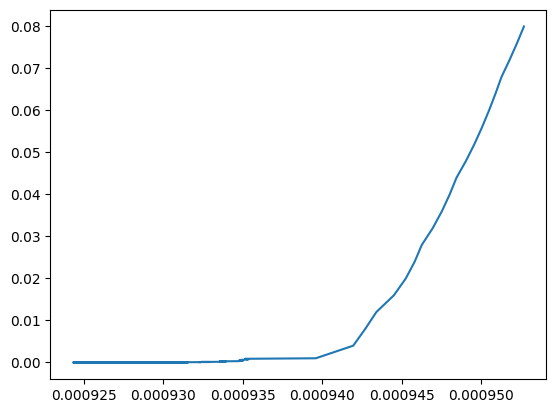

In [5]:
fig, ax = plt.subplots()
ax.plot(crust_chemical_potential/1000, crust_number_density);

We need a mean and kernel for our GP

In [6]:
def phi(cs2):
    return -np.log(1/cs2 - 1)

In [7]:
# I believe they just have a constant for the mean?
def mean(cs2_bar):
    return phi(cs2_bar)

def K(n, nprime, eta, l):
    return eta*np.exp(-(n-nprime)**2/(2*l**2))

Hyperparameters are drawn from normal distributions

In [8]:
l = rng.normal(loc=1*nsat, scale=0.25*nsat)
eta = rng.normal(loc=1.25, scale=0.2)
cs2_bar = rng.normal(loc=0.5, scale=0.25)

We also want to condition the EOS at low densities with some predictions from the literature. We take the average and the difference of the "soft" and "stiff" EOS from [Hebeler et al. (2013)](https://arxiv.org/abs/1303.4662) as the mean and 90% credible interval of the training data used to condition the EOS.

In [9]:
soft_eos = pd.read_csv('../data/soft_eos.csv')

soft_number_density = soft_eos['n/n0'].values
chiEFT_mask = soft_number_density <= 1.1

soft_number_density = soft_number_density[chiEFT_mask]*nsat
soft_pressure = soft_eos['p'].values[chiEFT_mask]/1000
soft_energy_density = soft_eos['epsilon'].values[chiEFT_mask]/1000

soft_chemical_potential = (
    soft_energy_density+soft_pressure
    )/soft_number_density

soft_speed_of_sound_squared = np.gradient(
    soft_pressure, soft_energy_density
)

In [10]:
stiff_eos = pd.read_csv('../data/stiff_eos.csv')

stiff_number_density = stiff_eos['n/n0'].values
chiEFT_mask = stiff_number_density <= 1.1

stiff_number_density = stiff_number_density[chiEFT_mask]*nsat
stiff_pressure = stiff_eos['p'].values[chiEFT_mask]/1000
stiff_energy_density = stiff_eos['epsilon'].values[chiEFT_mask]/1000

stiff_chemical_potential = (
    stiff_energy_density+stiff_pressure
    )/stiff_number_density

stiff_speed_of_sound_squared = np.gradient(
    stiff_pressure, stiff_energy_density
)

In [11]:
soft_phi = phi(soft_speed_of_sound_squared)
stiff_phi = phi(stiff_speed_of_sound_squared)

training_n = soft_number_density
training_phi = np.mean([soft_phi, stiff_phi], axis=0)
psi = (stiff_phi - soft_phi)/(2*1.645)

In [12]:
# mean_speed_of_sound_squared = np.mean(
#     [soft_speed_of_sound_squared, stiff_speed_of_sound_squared],
#     axis=0
#     )

In [13]:
# The training data
# training_n = soft_number_density
# training_phi = phi(mean_speed_of_sound_squared)

In [14]:
# The 1-sigma uncertainty
# psi = (stiff_speed_of_sound_squared - soft_speed_of_sound_squared) # /(2*1.645)

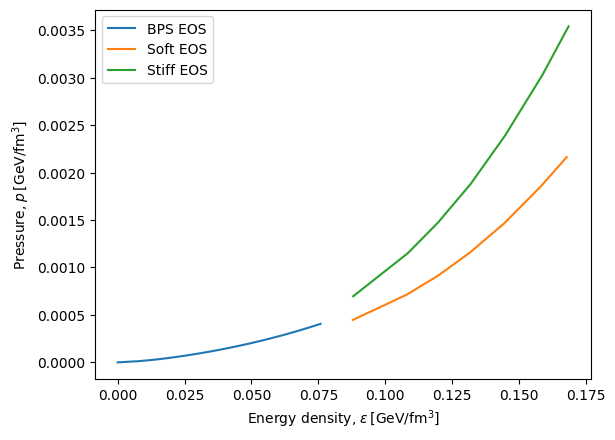

In [15]:
fig, ax = plt.subplots()

ax.plot(crust_energy_density, crust_pressure, label='BPS EOS')
ax.plot(soft_energy_density, soft_pressure, label='Soft EOS')
ax.plot(stiff_energy_density, stiff_pressure, label='Stiff EOS')

ax.legend()

ax.set_xlabel('Energy density, $\epsilon\,[\mathrm{GeV}/\mathrm{fm}^3]$')
ax.set_ylabel('Pressure, $p\,[\mathrm{GeV}/\mathrm{fm}^3]$');

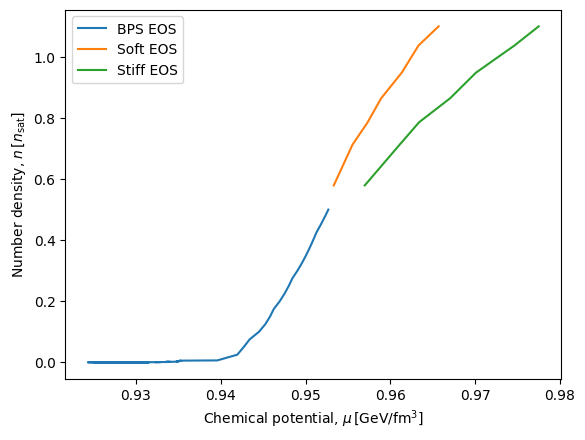

In [16]:
fig, ax = plt.subplots()

ax.plot(crust_chemical_potential, crust_number_density/nsat, label='BPS EOS')
ax.plot(soft_chemical_potential, soft_number_density/nsat, label='Soft EOS')
ax.plot(stiff_chemical_potential, stiff_number_density/nsat, label='Stiff EOS')

ax.legend()

ax.set_xlabel('Chemical potential, $\mu\,[\mathrm{GeV}/\mathrm{fm}^3]$')
ax.set_ylabel('Number density, $n\,[n_\mathrm{sat}]$');

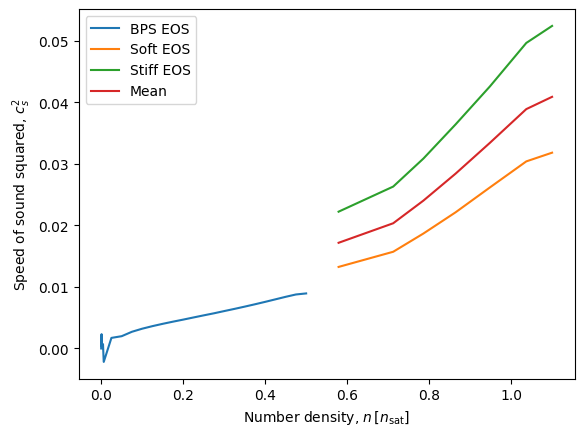

In [17]:
fig, ax = plt.subplots()

ax.plot(crust_number_density/nsat, crust_speed_of_sound_squared, label='BPS EOS')
ax.plot(soft_number_density/nsat, soft_speed_of_sound_squared, label='Soft EOS')
ax.plot(stiff_number_density/nsat, stiff_speed_of_sound_squared, label='Stiff EOS')
ax.plot(soft_number_density/nsat, 1/(np.exp(-training_phi) + 1), label='Mean')

ax.legend()

ax.set_xlabel('Number density, $n\,[n_\mathrm{sat}]$')
ax.set_ylabel('Speed of sound squared, $c_s^2$');

In [18]:
nL = soft_number_density[0]
nH = 10*nsat
n_points = 500

n_array = np.linspace(nL, nH, num=n_points)

In [19]:
training_dim = len(training_n)

In [20]:
n_array_prime = np.append(training_n, n_array)

In [41]:
repeats = 100
phi_draws = []

for _ in range(repeats):

    # Draw hyperparameters
    l = rng.normal(loc=1*nsat, scale=0.25*nsat)
    eta = rng.normal(loc=1.25, scale=0.2)
    cs2_bar = rng.normal(loc=0.5, scale=0.25)

    mu = mean(cs2_bar)

    # Construct the covariance matrix
    Sigma = np.zeros((n_points + training_dim, n_points + training_dim))
    for i, n in enumerate(n_array_prime):
        for j, nprime in enumerate(n_array_prime):
            Sigma[i, j] = K(n, nprime, eta, l)

    # Condition

    sigma_XX = Sigma[training_dim:, training_dim:]
    sigma_YY = Sigma[:training_dim, :training_dim] + psi**2*np.eye(training_dim)

    sigma_XY = Sigma[training_dim:, :training_dim]
    sigma_YX = Sigma[:training_dim, training_dim:]

    sigma_YY_inv = np.linalg.inv(sigma_YY)

    mup = mu + sigma_XY @ sigma_YY_inv @ (training_phi - mu)
    Sigmap = sigma_XX - sigma_XY @ sigma_YY_inv @ sigma_YX

    # Draw phi(n)
    phi_draws.append(rng.multivariate_normal(mup, Sigmap))

/var/folders/x6/wnwfrzv1471c46w4cryby1pw0000gn/T/ipykernel_8161/2845575757.py:2: RuntimeWarning: invalid value encountered in log
  return -np.log(1/cs2 - 1)


In [42]:
phi_draws = np.array(phi_draws)

In [43]:
cs2_draws = 1/(np.exp(-phi_draws) + 1)

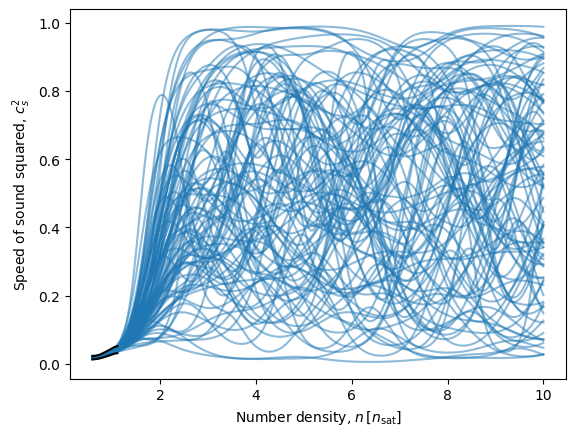

In [44]:
fig, ax = plt.subplots()

for cs2_draw in cs2_draws:
    ax.plot(n_array/nsat, cs2_draw, c='C0', alpha=0.5)

ax.plot(soft_number_density/nsat, soft_speed_of_sound_squared, c='k')
ax.plot(stiff_number_density/nsat, stiff_speed_of_sound_squared, c='k')

ax.set_xlabel('Number density, $n\,[n_\mathrm{sat}]$')
ax.set_ylabel('Speed of sound squared, $c_s^2$');

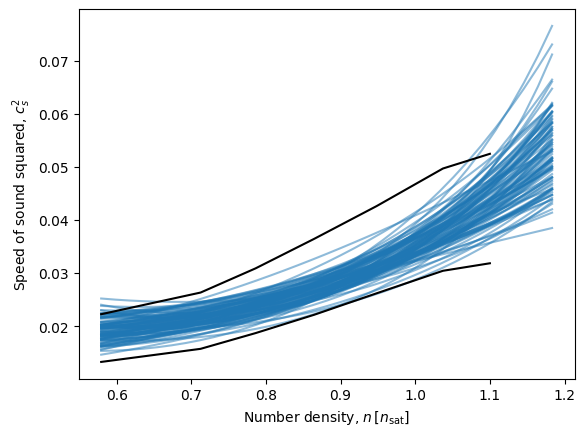

In [45]:
fig, ax = plt.subplots()

plot_mask = n_array < 1.2*nsat

for cs2_draw in cs2_draws:
    ax.plot(n_array[plot_mask]/nsat, cs2_draw[plot_mask], c='C0', alpha=0.5)

ax.plot(soft_number_density/nsat, soft_speed_of_sound_squared, c='k')
ax.plot(stiff_number_density/nsat, stiff_speed_of_sound_squared, c='k')

ax.set_xlabel('Number density, $n\,[n_\mathrm{sat}]$')
ax.set_ylabel('Speed of sound squared, $c_s^2$');

In [46]:
# mu0 = crust_chemical_potential[-1]
mu0 = (soft_chemical_potential[0] + stiff_chemical_potential[0])/2

In [47]:
mu_draws = []

for cs2_draw in cs2_draws:
    mu_draws.append(mu0*np.exp(cumulative_trapezoid(y=cs2_draw/n_array, x=n_array, initial=0)))

mu_draws = np.array(mu_draws)

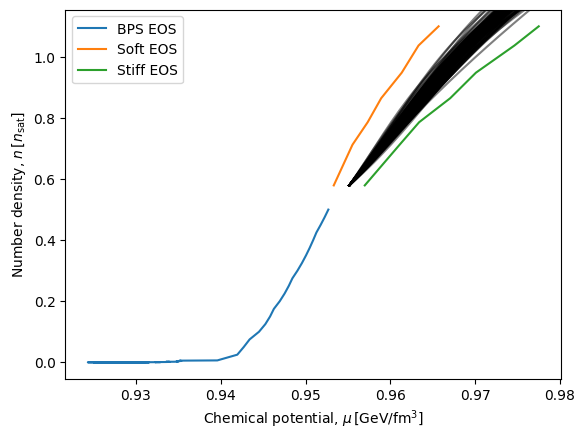

In [48]:
fig, ax = plt.subplots()

ax.plot(crust_chemical_potential, crust_number_density/nsat, label='BPS EOS')
ax.plot(soft_chemical_potential, soft_number_density/nsat, label='Soft EOS')
ax.plot(stiff_chemical_potential, stiff_number_density/nsat, label='Stiff EOS')

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for mu_draw in mu_draws:
    ax.plot(mu_draw, n_array/nsat, c='k', alpha=0.5)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend()

ax.set_xlabel('Chemical potential, $\mu\,[\mathrm{GeV}/\mathrm{fm}^3]$')
ax.set_ylabel('Number density, $n\,[n_\mathrm{sat}]$');

In [49]:
epsilon0 = (soft_energy_density[0] + stiff_energy_density[0])/2

In [50]:
epsilon_draws = []
for mu_draw in mu_draws:
    epsilon_draws.append(epsilon0 + cumulative_trapezoid(y=mu_draw, x=n_array, initial=0))
epsilon_draws = np.array(epsilon_draws)

In [51]:
p_draws = -epsilon_draws + mu_draws*n_array

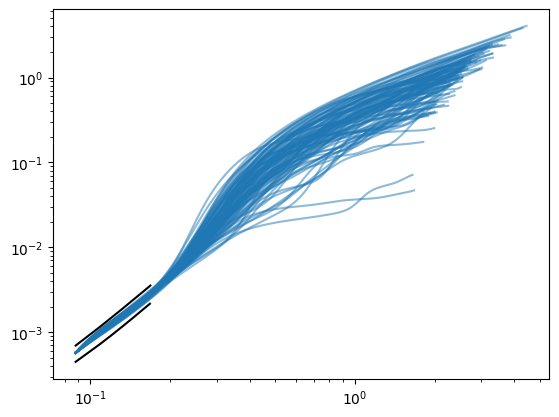

In [52]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

for epsilon_draw, p_draw in zip(epsilon_draws, p_draws):
    ax.plot(epsilon_draw, p_draw, c='C0', alpha=0.5)

ax.plot(soft_energy_density, soft_pressure, c='k')
ax.plot(stiff_energy_density, stiff_pressure, c='k')

# ax.set_ylim(1e-3)

In [33]:
import pqcd

In [34]:
X_array = np.linspace(0.5, 2, num=50)
muH_array = np.linspace(2.2, 2*2.6, num=50)

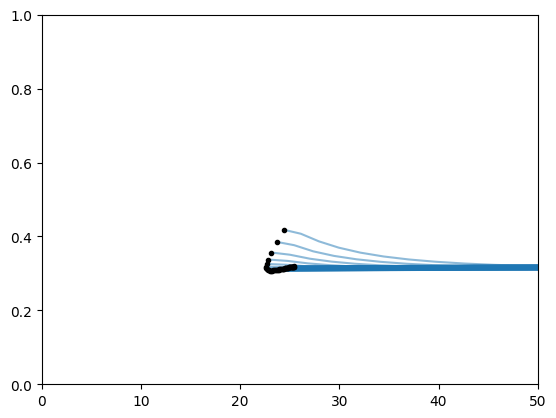

In [35]:
fig, ax = plt.subplots()

for X in X_array:

    pQCDX = pqcd.pQCD(X)

    p_list = []
    n_list = []
    epsilon_list = []

    for muH in muH_array:
        nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
        epsilonH = pqcd.epsilon_func(muH, nH, pH)
        p_list.append(pH)
        n_list.append(nH)
        epsilon_list.append(epsilonH)

    ax.plot(np.array(n_list)/nsat, np.gradient(p_list, epsilon_list), c='C0', alpha=0.5)
    ax.plot(n_list[0]/nsat, np.gradient(p_list, epsilon_list)[0], '.', c='k')

ax.set_xlim(0,50)
ax.set_ylim(0,1);

In [36]:
np.gradient(p_list, epsilon_list)

array([0.31881955, 0.31901264, 0.31940367, 0.31977032, 0.32011474,
       0.32043888, 0.32074446, 0.32103301, 0.32130592, 0.32156442,
       0.32180961, 0.3220425 , 0.32226399, 0.3224749 , 0.32267599,
       0.32286791, 0.3230513 , 0.32322671, 0.32339465, 0.32355561,
       0.32371001, 0.32385825, 0.32400069, 0.32413769, 0.32426954,
       0.32439654, 0.32451896, 0.32463705, 0.32475103, 0.32486112,
       0.32496752, 0.32507043, 0.32517   , 0.32526641, 0.32535981,
       0.32545034, 0.32553814, 0.32562332, 0.32570602, 0.32578633,
       0.32586437, 0.32594023, 0.326014  , 0.32608578, 0.32615564,
       0.32622366, 0.32628993, 0.3263545 , 0.32641744, 0.32644907])